# Business Understanding

# Data Understanding
First we'll import the data and try to understand its features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats

df = pd.read_csv('data/kc_house_data.csv')

In [2]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

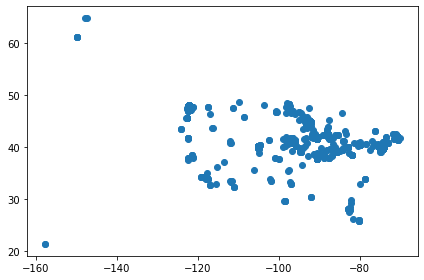

In [3]:
fig, ax = plt.subplots()

ax.scatter(df['long'],df['lat'])

fig.tight_layout();

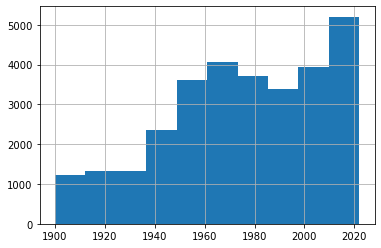

In [4]:
df['yr_built'].hist();

In [5]:
df['price'].describe()

count    3.015500e+04
mean     1.108536e+06
std      8.963857e+05
min      2.736000e+04
25%      6.480000e+05
50%      8.600000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64

In [6]:
len(df[df.duplicated()])

1

We'll drop the single duplicated record.

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(col, df[col].isna().sum()) 

heat_source 32
sewer_system 14


Later we'll create a feature that can compare values to neighbors. Perhaps we can infer these values from what seems to be popular with neighbors of these listings.

## BIG PARAGRAPH ABOUT DATA UNDERSTANDING

# Data Preparation
## Adding and Adjusting Columns
### Creating and Extracting, Based on Existing Columns

There are a few relatively obvious features we can create that should help us understand this data set:
- price-per-square-foot (from price and sqft_living_area)
- city (from address)
- state (from address)
- zip (from address)

In [9]:
df['ppsqft'] = df['price'] / df['sqft_living']
df['state'] = df['address'].apply(lambda x: str(x).split(' ')[-4])
df['zip'] = df['address'].apply(lambda x: str(x).split(' ')[-3].replace(',', ''))
df['city'] = df['address'].apply(lambda x: str(x).split(',')[-3].strip())

### Label Encoding
The "view", "condition", and "grade" fields should all be label-encoded.

In [10]:
def view(x):
    if x == 'NONE':
        return 0
    elif x == 'FAIR':
        return 1
    elif x == 'AVERAGE':
        return 2
    elif x == 'GOOD':
        return 3
    elif x == 'EXCELLENT':
        return 4

df['view'] = df['view'].apply(lambda x: view(x))

def condition(x):
    if x == 'Poor':
        return 0
    elif x == 'Fair':
        return 1
    elif x == 'Average':
        return 2
    elif x == 'Good':
        return 3
    elif x == 'Very Good':
        return 4

df['condition'] = df['condition'].apply(lambda x: condition(x))

df['grade'] = df['grade'].apply(lambda x: int(x[:2].strip()))

The "year renovated" has a zero value for most of the entries, which is not mathematically compatible. We'll create some more relevant fields: From the "date" feature we'll extract the "year of sale" and then the "age" of the house. Then for renovations we'll assume a new build is as good as a renovation, so "years since renovation" can just be the same as a house's age if it's never been renovated.

In [11]:
df['year_of_sale'] = df['date'].apply(lambda x: int(x[-4:]))
df['age'] = df['year_of_sale'] - df['yr_built']
df['years_since_renovation'] = df.apply(
    lambda x: x.age if x.yr_renovated == 0 else x.year_of_sale - x.yr_renovated, axis=1)

## Exploring the Data Via Lat/Long Maps and Removing Out-of-Range Records

Let's get an idea of where these listings are. We can do so by making a scatterplot of the longitude and latitude entries.

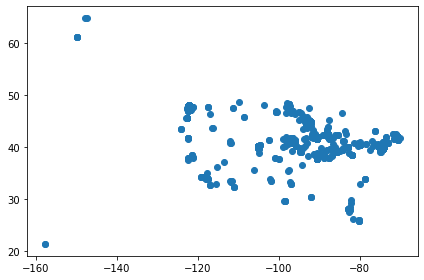

In [12]:
fig, ax = plt.subplots()
ax.scatter(df['long'],df['lat'])
fig.tight_layout();

For some reason, this appears to include listings from nearly all 50 states, while were supposed to be focusing on just one county in Washington.

In [13]:
print('Total listings: ' + str(len(df)))
print('Out of state listings: ' + str(len(df[df['state'] != 'Washington'])))

Total listings: 30154
Out of state listings: 910


We'll get rid of out-of-state listings and look just at Washington.

In [14]:
# group the indices of 'bad' records in a set to be dropped
out_of_range = set(df[df['state'] != 'Washington'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

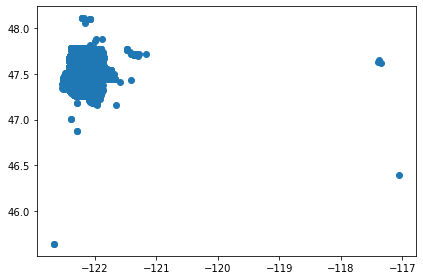

In [15]:
fig, ax = plt.subplots()
ax.scatter(df_map['long'],df_map['lat'])
fig.tight_layout();

In [16]:
df['city'].value_counts()

Seattle          9372
Renton           1946
Kent             1583
Bellevue         1530
Auburn           1513
                 ... 
Effingham           1
North Edwards       1
Williston           1
Kandiyohi           1
Fairbanks           1
Name: city, Length: 315, dtype: int64

There are still some far-flung properties in places like Spokane. We could just include/exclude based on the "city" field, but there are 315 unique cities, too many to sort in any simple way.

We can look up cities using long/lat approaching from all directions and eliminate anything that isn't in King County. (We can just look up what county the city belongs to on Wikipedia.)

In [17]:
# from the east
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=False)[:5]

,long
city,
Clarkston,-117.056550
Spokane,-117.375921
Skykomish,-121.332524
Snoqualmie Pass,-121.417590
Baring,-121.470469


In [18]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Clarkston'].index)
out_of_range.update(df[df['city'] == 'Spokane'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

In [19]:
# from the south
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=True)[:5]

,lat
city,
Vancouver,45.636805
Eatonville,46.876426
Spanaway,47.002985
Puyallup,47.178090
Enumclaw,47.212415


In [20]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Vancouver'].index)
out_of_range.update(df[df['city'] == 'Eatonville'].index)
out_of_range.update(df[df['city'] == 'Spanaway'].index)
out_of_range.update(df[df['city'] == 'Puyallup'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

This region features two cities, Milton and Auburn, that spill over into neighboring Pierce County to the south.

In [21]:
df_map[
       (df_map['lat'] < 47.257510) &
       (df_map['long'] < -122.144411)
      ][['address', 'price', 'sqft_living', 'sqft_lot', 'bedrooms']]

,address,price,sqft_living,sqft_lot,bedrooms
1236,"4018 South 384th Street, Auburn, Washington 98...",380000.0,1250,18700,3
24148,"1901 Alder Place, Milton, Washington 98354, Un...",610000.0,1610,9644,4
27679,"98 27th Avenue, Milton, Washington 98354, Unit...",550000.0,1840,9851,4


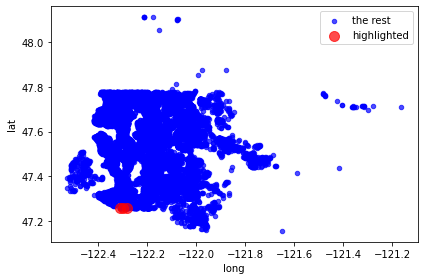

In [22]:
highlight = df_map[
       (df_map['lat'] < 47.257510) &
       (df_map['long'] < -122.144411)
      ].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots()

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend()

fig.tight_layout();

There are 3 more listings that are essentially contiguous with the rest of the records, but technically belong to another county. They don't otherwise appear anomalous, so we'll keep them.

In [23]:
# from the north
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=False)[:8]

,lat
city,
Tulalip,48.111504
Arlington,48.100735
Marysville,48.082740
Monroe,47.824948
Snohomish,47.811287
Baring,47.760969
Lake Forest Park,47.759078
Bothell,47.757407


In [24]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Tulalip'].index)
out_of_range.update(df[df['city'] == 'Arlington'].index)
out_of_range.update(df[df['city'] == 'Marysville'].index)
out_of_range.update(df[df['city'] == 'Monroe'].index)
out_of_range.update(df[df['city'] == 'Snohomish'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

In [25]:
# from the west
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=True)[:5]

,long
city,
Vashon,-122.467801
Dilworth,-122.439530
Dash Point,-122.416100
White Center,-122.363360
Normandy Park,-122.343426


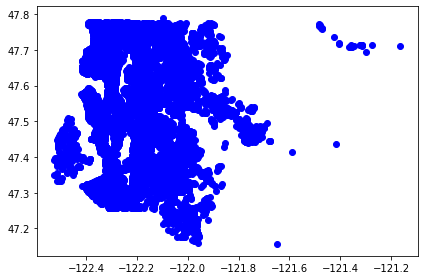

In [26]:
fig, ax = plt.subplots()
ax.scatter(df_map['long'],df_map['lat'], color="blue")
fig.tight_layout();

We'll investigate the dot by itself that looks like it's just above the county line.

In [27]:
df_map.sort_values('lat', ascending=False)[:3][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
24605,47.78983,-122.097078,Woodinville,98077
25634,47.77764,-122.376830,Shoreline,98177
29110,47.77758,-122.352405,Shoreline,98133


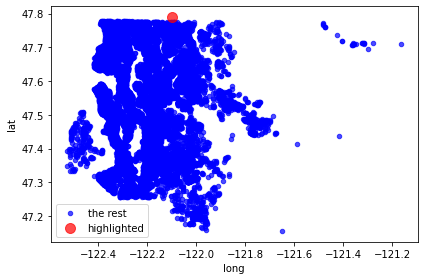

In [28]:
highlight = [24605]

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots()

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend()

fig.tight_layout();

The single northernmost anomalous dot is at a latitude located neither in King County nor in Woodinville. It could be an error, but we wouldn't know how to correct it, so we'll drop it.

In [29]:
# update the set of indices of 'bad' records to be dropped
out_of_range.add(24605)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the strip of dots to the northeast along State Highway 2.

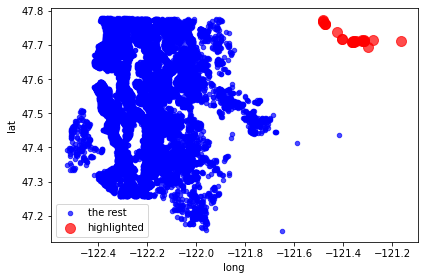

In [30]:
highlight = df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots()

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend()

fig.tight_layout();

In [31]:
df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)]['city'].value_counts()

Skykomish    19
Baring        7
Name: city, dtype: int64

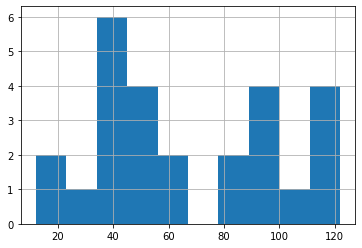

In [32]:
df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)]['age'].hist();

There are 26 listings along State Highway 2 that are pretty far out from the main urban area. This appears to be about an hour's drive in good traffic from the rest of the city. It doesn't seem relevant enough to the data set to keep, so we'll drop them.

In [33]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the stray dot to the south.

In [34]:
df_map[(df_map['lat'] < 47.2) & (df_map['long'] > -121.8)][['city', 'lat', 'long', 'address']]

,city,lat,long,address
2930,Enumclaw,47.155265,-121.648225,"52309 SE 496th Pl, Enumclaw, Washington 98022,..."


In [35]:
df[df['city'] == 'Enumclaw']['zip'].value_counts()

98022    459
98092      1
Name: zip, dtype: int64

In [36]:
df[df['zip'] == '98092']['city'].value_counts()

Auburn      608
Enumclaw      1
Name: city, dtype: int64

This appears to be a remote community, far from the city it claims (Enumclaw) or the city normally associated with its zip code (Auburn). It doesn't appear to be an error, but it still represents a community with no immediate neighbors for comparison. As such, we'll drop it.

In [37]:
# update the set of indices of 'bad' records to be dropped
out_of_range.add(2930)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the stray dots in the middle by pinching the latitude and searching longitude from east to west.

In [38]:
df_map[(df_map['lat'] > 47.3)
       & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:8][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
17663,47.437030,-121.41759,Snoqualmie Pass,98045
20216,47.413610,-121.58837,North Bend,98045
14924,47.444770,-121.67469,North Bend,98045
11277,47.444905,-121.67554,North Bend,98045
28815,47.444655,-121.67839,North Bend,98045
28816,47.444745,-121.67879,North Bend,98045
8473,47.496180,-121.68674,North Bend,98045
15081,47.480100,-121.69844,North Bend,98045


Investigating these coordinates on Google Maps shows that he first three of these are something like the "Enumclaw" anomaly discussed earlier, but everything else appears to belong to a cluster worth keeping. We'll drop just those three.

In [39]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df_map[(df_map['lat'] > 47.3)
                           & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:3].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at two final listings that appear remotely located from the rest.

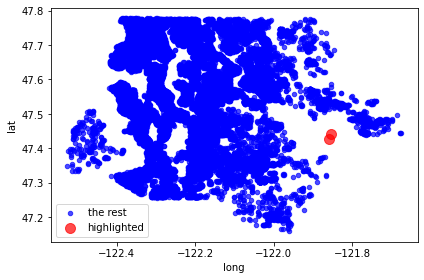

In [40]:
highlight = df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots()

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend()

fig.tight_layout();

In [41]:
df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ][['address', 'price', 'grade', 'condition', 'heat_source', 'sqft_living', 'sqft_lot', 'bathrooms']]

,address,price,grade,condition,heat_source,sqft_living,sqft_lot,bathrooms
20448,"19109 364th Avenue Southeast, Maple Valley, Wa...",885000.0,8,2,Gas,2240,305355,2.0
24342,"17800 364th Avenue Southeast, Maple Valley, Wa...",1115000.0,4,2,NaN,660,1210096,1.0


One of these is a "low grade" 1-bedroom that sold for $1.115 million, which raises enough questions. It would seem fair to drop both of them.

In [42]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update([20448, 24342])

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

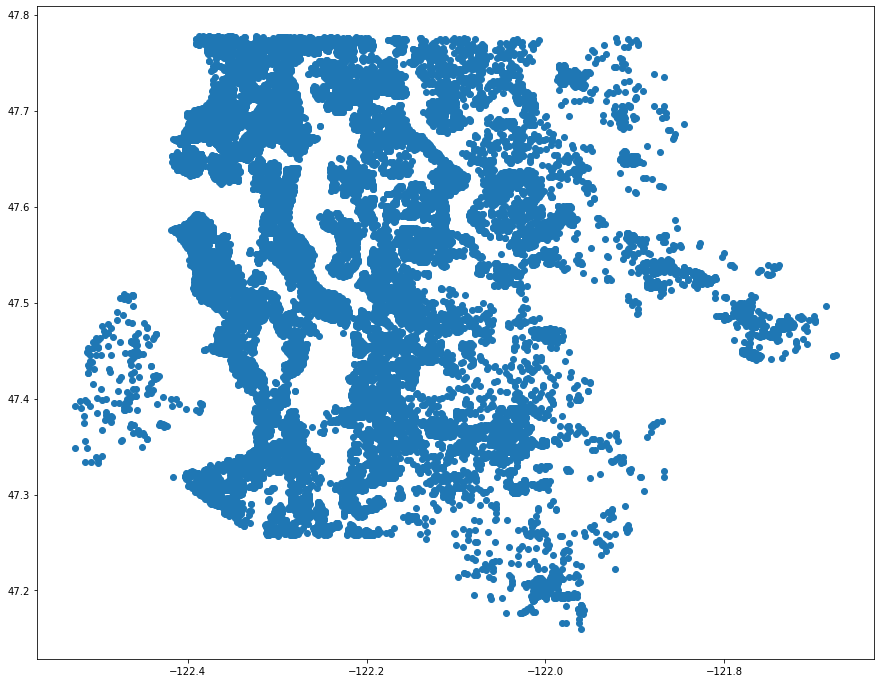

In [43]:
fig, ax = plt.subplots(figsize=(15,12))

ax.scatter(df_map['long'],df_map['lat']);

Geographically, at least, this looks like the data we want to work with.

In [44]:
print('We have dropped ' + str(len(df) - len(df_map)) + ' records, about '
      + str(round(100*(1 - len(df_map) / len(df)),2)) + '% of them.')

We have dropped 972 records, about 3.22% of them.


We'll lock in the changes to the main dataframe.

In [45]:
df = df_map.copy()

Now we'll build some functions that will give us a list of everyone's closest neighbors for the purpose of comparing values with listings nearby.

In [46]:
# compute the distance in feet between two coordinates
def distance(lat1, long1, lat2, long2):
    x = abs(lat2-lat1)*364732.89
    y = abs(long2-long1)*249526.96
    return np.sqrt(x**2 + y**2)

The "neighbors" function was developed over many drafts. The goal is to generate a list of neighbors for each listing. The criteria for inclusion are 1) proximity, as measured by the distance function, and 2) same or similar number of bedrooms. The idea is to find a list of properties worthy of comparison so that we can analyze what is essentially normal for homes of that size in that area and possibly identify anomalies indicitave of errors (and drop those records).

It isn't convenient or feasible to generate the same number of neighbors for every listing nor to limit each list of neighbors to the same radius for all listings. The best version of the function starts with a radius of 250 feet and either expands or contracts the radius until it generates a list of between 15 and 40 neighbors within that modified desired radius.

In [47]:
def neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count):
    # generate an initial list according to number of bedrooms
    if brs == 0:
        neighbor_list = df[
            (df['bedrooms'] < 2) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 1:
        neighbor_list = df[
            (df['bedrooms'] < 3) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 2:
        neighbor_list = df[
            (df['bedrooms'] > 0) & (df['bedrooms'] < 4) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 3:
        neighbor_list = df[
            (df['bedrooms'] > 1) & (df['bedrooms'] < 5) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs < 6:
        neighbor_list = df[
            (df['bedrooms'] > 2) & (df['bedrooms'] < 7) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs > 5:
        neighbor_list = df[
            (df['bedrooms'] > 4) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    
    # expand the radius and rerun if the list is too small
    if len(neighbor_list) < min_neighbor_count:
        too_small_factor = min_neighbor_count / len(neighbor_list)
        radius *= 3.5
        return neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count)
    # contract the radius and rerun if the list is too long
    elif len(neighbor_list) > max_neighbor_count:
        too_big_factor = max_neighbor_count / len(neighbor_list)
        radius *= 0.75
        return neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count)
    # accept the list otherwise
    else:
        return neighbor_list

This function helps generate new columns that show the median of a certain column value, e.g. living area, for all of a listing's neighbors (from its neighbor list).

In [48]:
def nearby(neighbor_list, column):
    return df.loc[neighbor_list][column].median()

The cells below create the neighbor lists and generates the 'nearby' features — the median value of a neighbor list for a given feature

**WARNING — the following cells take several minutes to run**

In [49]:
df['neighbor_list'] = df.apply(lambda x: neighbors(x.bedrooms, x.lat, x.long, 250, 15, 40), axis=1)

In [50]:
df['neighbor_counts'] =df['neighbor_list'].apply(lambda x: len(x))
df['neighbor_counts'].value_counts()

33    1447
34    1401
32    1391
30    1360
28    1356
31    1346
29    1334
27    1307
35    1306
26    1293
37    1247
36    1245
38    1160
25    1146
24    1127
39    1100
40    1084
22     973
15     938
23     919
16     862
21     842
20     767
18     765
17     746
19     720
Name: neighbor_counts, dtype: int64

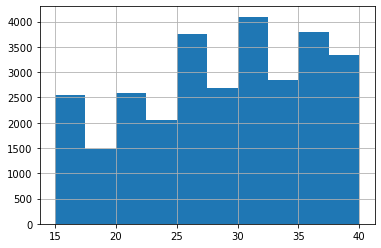

In [51]:
df['neighbor_counts'].hist();

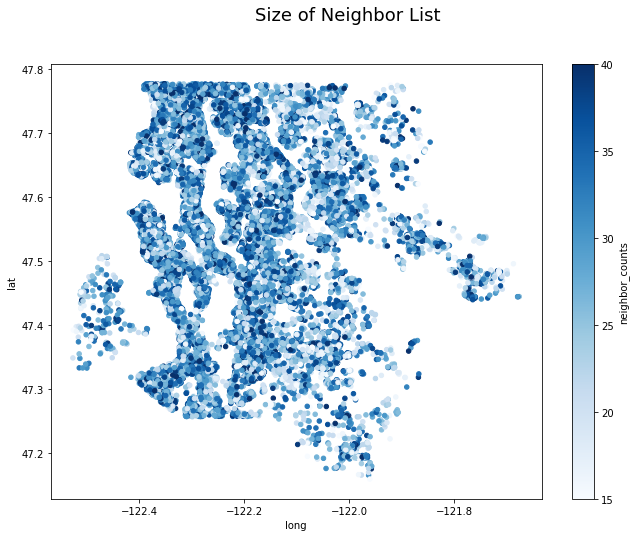

In [52]:
fig, ax = plt.subplots(figsize=(11,8))

df.plot.scatter(x='long', y='lat', c='neighbor_counts', cmap='Blues', ax=ax)
fig.suptitle('Size of Neighbor List', size=18);

In [53]:
df['nearby_price'] = df.apply(lambda x: nearby(x.neighbor_list, 'price'), axis=1)

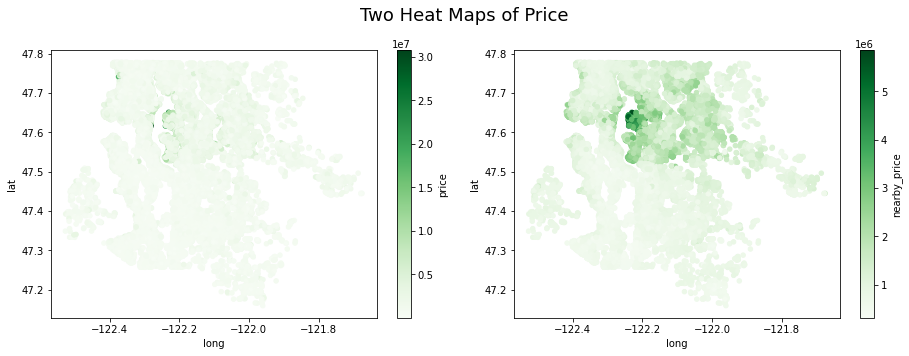

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='price', cmap='Greens', ax=ax1)
df.plot.scatter(x='long', y='lat', c='nearby_price', cmap='Greens', ax=ax2)
fig.suptitle('Two Heat Maps of Price', size=18)
fig.tight_layout();

In [55]:
df['nearby_sqft_living'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_living'), axis=1)

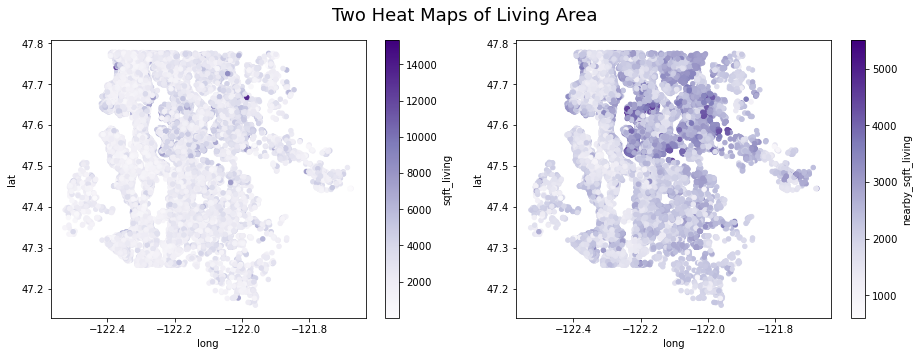

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='sqft_living', cmap='Purples', ax=ax1)
df.plot.scatter(x='long', y='lat', c='nearby_sqft_living', cmap='Purples', ax=ax2)
fig.suptitle('Two Heat Maps of Living Area', size=18)
fig.tight_layout();

In [57]:
df['nearby_sqft_lot'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_lot'), axis=1)

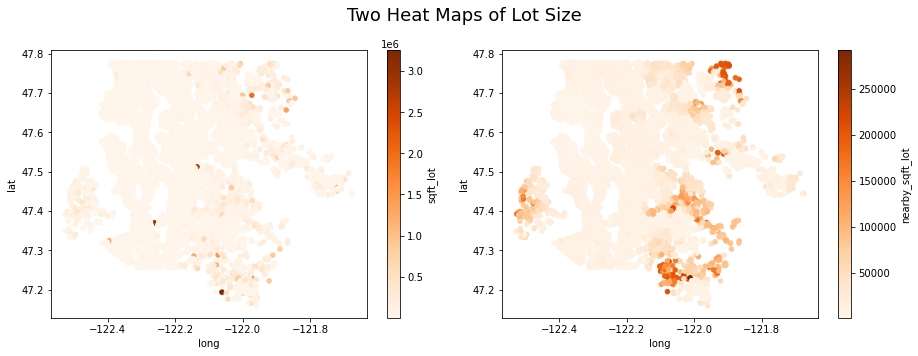

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='sqft_lot', cmap='Oranges', ax=ax1)
df.plot.scatter(x='long', y='lat', c='nearby_sqft_lot', cmap='Oranges', ax=ax2)
fig.suptitle('Two Heat Maps of Lot Size', size=18)
fig.tight_layout();

In [59]:
df['nearby_ppsqft'] = df.apply(lambda x: nearby(x.neighbor_list, 'ppsqft'), axis=1)

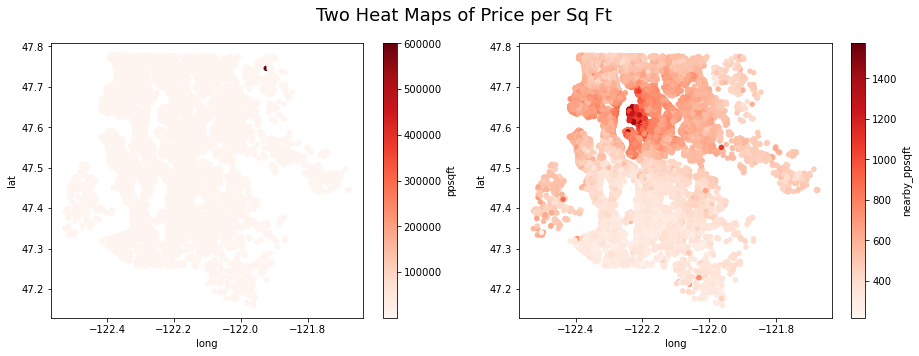

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='ppsqft', cmap='Reds', ax=ax1)
df.plot.scatter(x='long', y='lat', c='nearby_ppsqft', cmap='Reds', ax=ax2)
fig.suptitle('Two Heat Maps of Price per Sq Ft', size=18)
fig.tight_layout();

In [61]:
df['nearby_age'] = df.apply(lambda x: nearby(x.neighbor_list, 'age'), axis=1)

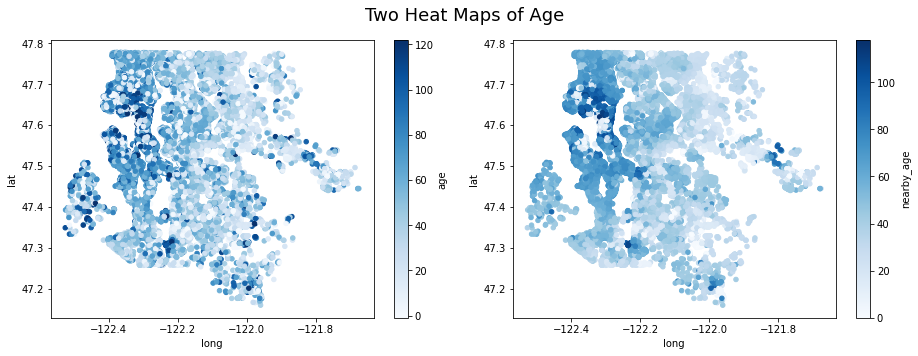

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df.plot.scatter(x='long', y='lat', c='age', cmap='Blues', ax=ax1)
df.plot.scatter(x='long', y='lat', c='nearby_age', cmap='Blues', ax=ax2)
fig.suptitle('Two Heat Maps of Age', size=18)
fig.tight_layout();

# DELETE THIS LATER

# THE CELL BELOW BOOKMARKS A DATAFRAME FOR REUSE

In [63]:
df_bookmark = df.copy()

As discussed at the very beginning, now we can interpolate missing values for heat source and sewer system. That is, for each listing with a missing value for heat source and/or sewer system, we'll assign the most popular value (mode) among that listing's neighbors.

In [64]:
for listing in df[df['sewer_system'].isna()].index:
    df.at[listing, 'sewer_system'] = df.loc[df.loc[listing]['neighbor_list']]['sewer_system'].mode()[0]
for listing in df[df['heat_source'].isna()].index:
    df.at[listing, 'heat_source'] = df.loc[df.loc[listing]['neighbor_list']]['heat_source'].mode()[0]

We can also use the neighbor list features to identify anomalous records that are possibly just errors. We can give each listing a score based on the factors by which it differs from its neighbors in certain values. For example, we'll see a listing whose living area ("3 sq ft") is orders of magnitude smaller than its neighbors.

(An earlier effort at this identified too many 'anomalies' by virtue of their exceptionally large lot areas, so we'll just look for exceptional values in price and living area.)

In [65]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'ppsqft', 'state', 'zip',
       'city', 'year_of_sale', 'age', 'years_since_renovation',
       'neighbor_list', 'neighbor_counts', 'nearby_price',
       'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft', 'nearby_age'],
      dtype='object')

In [66]:
def anom(val, neighbor_val):
    return max(val/neighbor_val, neighbor_val/val)

In [67]:
df['anomalous_price'] = df.apply(lambda x: anom(x.price, x.nearby_price),axis=1)
df['anomalous_sqft_living'] = df.apply(lambda x: anom(x.sqft_living, x.nearby_sqft_living),axis=1)
df['anomalous_ppsqft'] = df.apply(lambda x: anom(x.ppsqft, x.nearby_ppsqft),axis=1)

In [68]:
len(df[df['anomalous_price'] > 15])

34

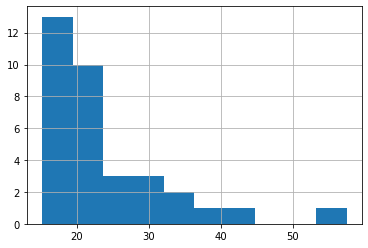

In [69]:
df[df['anomalous_price'] > 15]['anomalous_price'].hist();

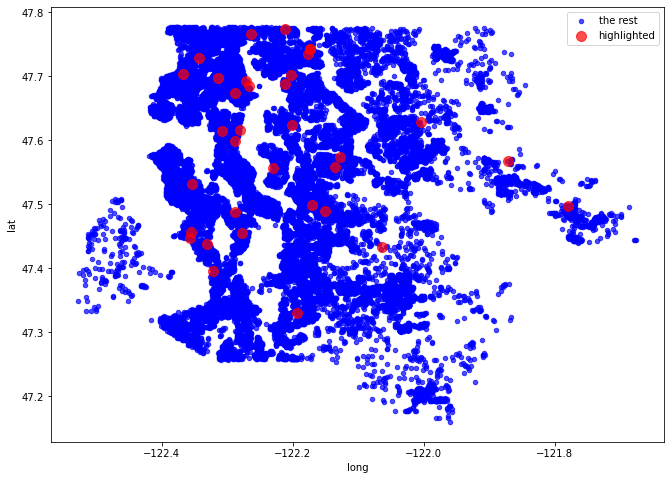

In [70]:
highlight = df.sort_values('anomalous_price', ascending=False)[:34].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(11,8))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

In [71]:
df.sort_values('anomalous_price', ascending=False)[:34][['price', 'nearby_price', 'address', 'city', 'zip']]

,price,nearby_price,address,city,zip
6430,40000.0,2300000.0,"2030 250th Place Northeast, Sammamish, Washing...",Sammamish,98074
23470,30750000.0,706000.0,"1620 Lake Washington Boulevard, Seattle, Washi...",Seattle,98122
9125,29941.0,1117500.0,"15724 124th Avenue Northeast, Woodinville, Was...",Woodinville,98072
14544,35000.0,1210000.0,"412 35th Avenue South, Seattle, Washington 981...",Seattle,98144
7577,28307.0,950000.0,"15708 124th Avenue Northeast, Woodinville, Was...",Woodinville,98072
25830,30108.0,955000.0,"34920 Southeast Fall City-Snoqualmie Road, Fal...",Fall City,98024
21793,27563.0,852500.0,"1528 19th Avenue, Seattle, Washington 98122, U...",Seattle,98122
20406,28559.0,823500.0,"417 Hoquiam Place Northeast, Renton, Washingto...",Renton,98059
17140,54241.0,1456500.0,"15244 Southeast 49th Street, Bellevue, Washing...",Bellevue,98006
14797,50000.0,1253500.0,"6221 37th Avenue Northeast, Seattle, Washingto...",Seattle,98115


The prices that are way lower than normal (for their neighborhood) seem like mistakes, and the prices that are way higher than normal might just be mansions or expansive ranches.

It seems helpful to get rid of the likely mistakes (unusually low prices).

In [72]:
df.drop(df[
    (df['price'] < 100000) & (df['anomalous_price'] > 15)
].index, inplace=True)

As for the unusually high prices, we can perhaps address those as outliers of the greater data set, not just compared to their neighbors.

In [73]:
threshold = 9.8
outliers = set(df[df['price'] > df['price'].mean() + threshold * df['price'].std()].index)

print('There are', len(outliers), 'listings with a price of at least', min(df.loc[outliers]['price']))

There are 26 listings with a price of at least 10000000.0


Let's drop everything $10 million and above.

In [74]:
df.drop(df[df['price'] >= 10000000].index, inplace=True)

In [75]:
len(df[df['anomalous_sqft_living'] > 3])

42

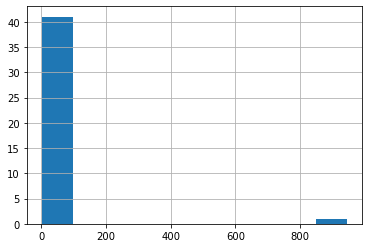

In [76]:
df[df['anomalous_sqft_living'] > 3]['anomalous_sqft_living'].hist();

Whoa. Let's get rid of the crazy outlier and try this again.

In [77]:
df.drop(df[df['anomalous_sqft_living'] > 200].index, inplace=True)

In [78]:
len(df[df['anomalous_sqft_living'] > 3])

41

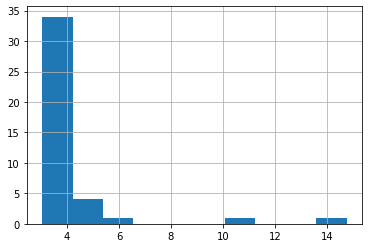

In [79]:
df[df['anomalous_sqft_living'] > 3]['anomalous_sqft_living'].hist();

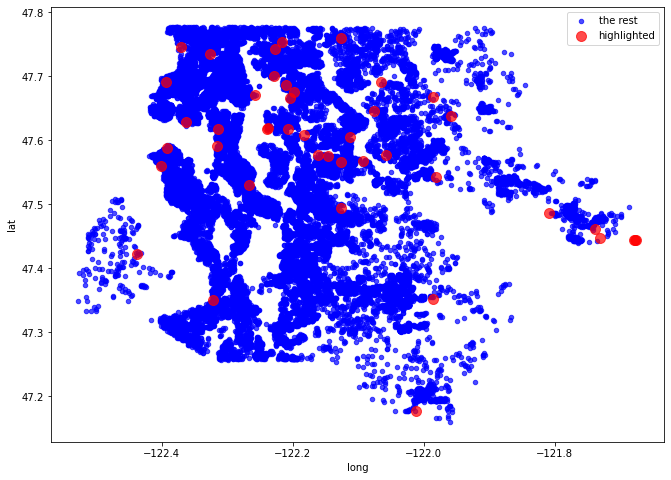

In [80]:
highlight = df.sort_values('anomalous_sqft_living', ascending=False)[:43].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(11,8))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

In [81]:
df.sort_values('anomalous_sqft_living', ascending=False)[:41][[
    'sqft_living', 'nearby_sqft_living', 'bedrooms', 'address', 'city', 'zip']]

,sqft_living,nearby_sqft_living,bedrooms,address,city,zip
28816,100,1475.0,1,"49622 172nd Street Southeast, North Bend, Wash...",North Bend,98045
14827,7710,755.0,0,"1727 15th Avenue, Seattle, Washington 98122, U...",Seattle,98122
3431,290,1680.0,1,"160 118th Avenue Southeast, Bellevue, Washingt...",Bellevue,98005
5219,10750,2105.0,5,"450 West Lake Sammamish Parkway Southeast, Bel...",Bellevue,98008
10158,670,3140.0,3,"18212 160th Ave NE, Woodinville, Washington 98...",Woodinville,98072
7119,7390,1640.0,5,"12048 160th Avenue Southeast, Renton, Washingt...",Renton,98059
28815,170,755.0,0,"49702 172nd Street Southeast, North Bend, Wash...",North Bend,98045
1948,12300,2980.0,5,"4121 198th Court Northeast, Sammamish, Washing...",Sammamish,98074
6125,400,1590.0,1,"16010 Southeast 45th Street, Bellevue, Washing...",Bellevue,98006
300,7820,1990.0,3,"4750 54th Avenue Southwest, Seattle, Washingto...",Seattle,98116


In [82]:
df.sort_values('sqft_living', ascending=True)[['sqft_living', 'bedrooms', 'price']][:20]

,sqft_living,bedrooms,price
28816,100,1,205000.0
28815,170,0,205000.0
25133,210,0,525000.0
8694,260,0,1160000.0
8391,290,0,1625000.0
23622,290,0,960000.0
3431,290,1,2500000.0
11989,310,1,695000.0
476,320,1,405000.0
13015,320,0,489962.0


Any dwelling under 500 sqft seems quite small, and anything under 250 seems nearly impossible. The number of bedrooms seems right for small dwellings (all 0 or 1) but some of these tiny studio apartments seem to be fetching sums of more than 1 million. Let's drop all dwellings under 250 sqft, anything under 325 that's selling for 750,000+, and anything under 425 that's over 1 million.

In [83]:
df.drop(df[
    (df['sqft_living'] < 250) |
    (df['sqft_living'] < 325) &
    (df['price'] > 750000) |
    (df['sqft_living'] < 425) &
    (df['price'] > 1000000)
].index, inplace=True)

## Looking at Zip Codes

Let's group zip codes, by mean price, into 8 bins that correspond as closely as possible with 1/8 of the data each.

In [84]:
df_zip = df.groupby('zip')['price'].mean()

num_tiers = 8

zip_tier = []

for q in range(num_tiers):
    zip_tier.append([])
    lower = df['price'].quantile(q/num_tiers)
    upper = df['price'].quantile((q+1)/num_tiers)
    zip_tier[q] = list(df_zip[(df_zip > lower) & (df_zip < upper)].index)

def zip_tiering(zip_code):
    for q in range(num_tiers):
        if zip_code in zip_tier[q]:
            return q

df['zip_tier'] = df['zip'].apply(lambda x: zip_tiering(x))

In [85]:
df['zip_tier'].value_counts()

5    6919
6    4594
2    4157
1    3880
3    3558
4    2826
7    2736
0     443
Name: zip_tier, dtype: int64

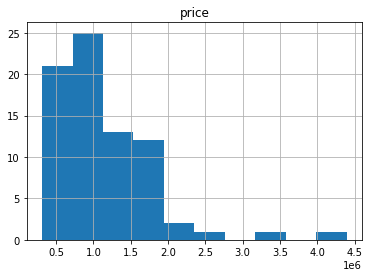

In [86]:
df.groupby('zip').agg({'price': 'mean'}).hist();

## Exploring Multicollinearity

In [87]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_mc=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_mc['pairs'] = list(zip(df_mc.level_0, df_mc.level_1))

# set index to pairs
df_mc.set_index(['pairs'], inplace = True)

# drop level columns
df_mc.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_mc.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themse
# for the sake of exercise, kept it in.
df_mc.drop_duplicates(inplace=True)

In [88]:
df_mc[(df_mc.cc > .62) & (df_mc.cc < 1)]

,cc
pairs,
"(age, yr_built)",0.999885
"(years_since_renovation, age)",0.908710
"(years_since_renovation, yr_built)",0.908500
"(sqft_living, sqft_above)",0.880036
"(zip_tier, nearby_ppsqft)",0.798899
"(anomalous_ppsqft, anomalous_price)",0.796627
"(sqft_living, bathrooms)",0.778298
"(price, nearby_price)",0.760365
"(zip_tier, nearby_price)",0.740965


Most notable here are a few strong predictors of price (nearby_ppsqft, nearby_price) and a few likely instances of actual multicollinearity, namely sqft_living paired with each of sqft_above, bathrooms, and grade.

## Exploring Log Transformations

In [89]:
df['log_price'] = np.log(df['price'])

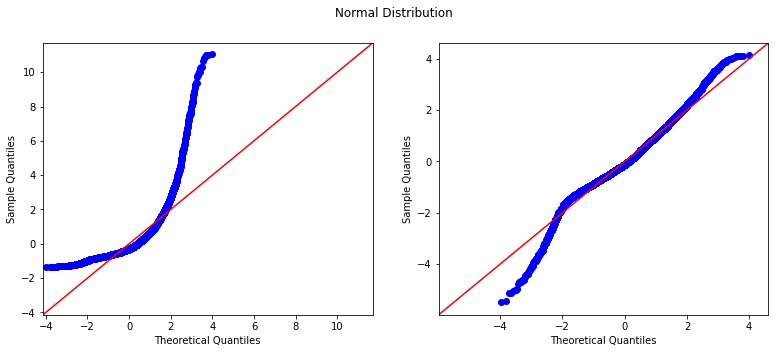

In [90]:
# Use qqplot function from StatsModels
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))
sm.graphics.qqplot(df['price'], line='45', fit=True, ax=ax1)
sm.graphics.qqplot(df['log_price'], line='45', fit=True, ax=ax2)

fig.suptitle("Normal Distribution");

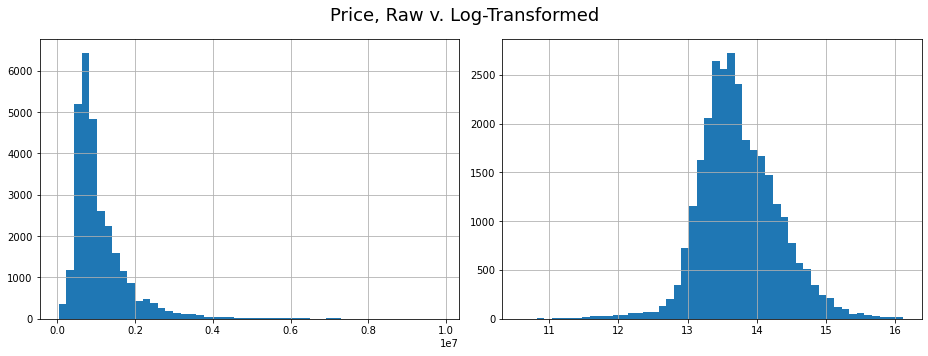

In [91]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,5))

df['price'].hist(ax = ax1, bins=50)
df['log_price'].hist(ax = ax2, bins=50)

fig.suptitle('Price, Raw v. Log-Transformed', size=18)
fig.tight_layout();

Log-transforming the price clearly gives us a closer to normal set of target values to work with.

Let's consider which of the features possibly warrant log-transforming.

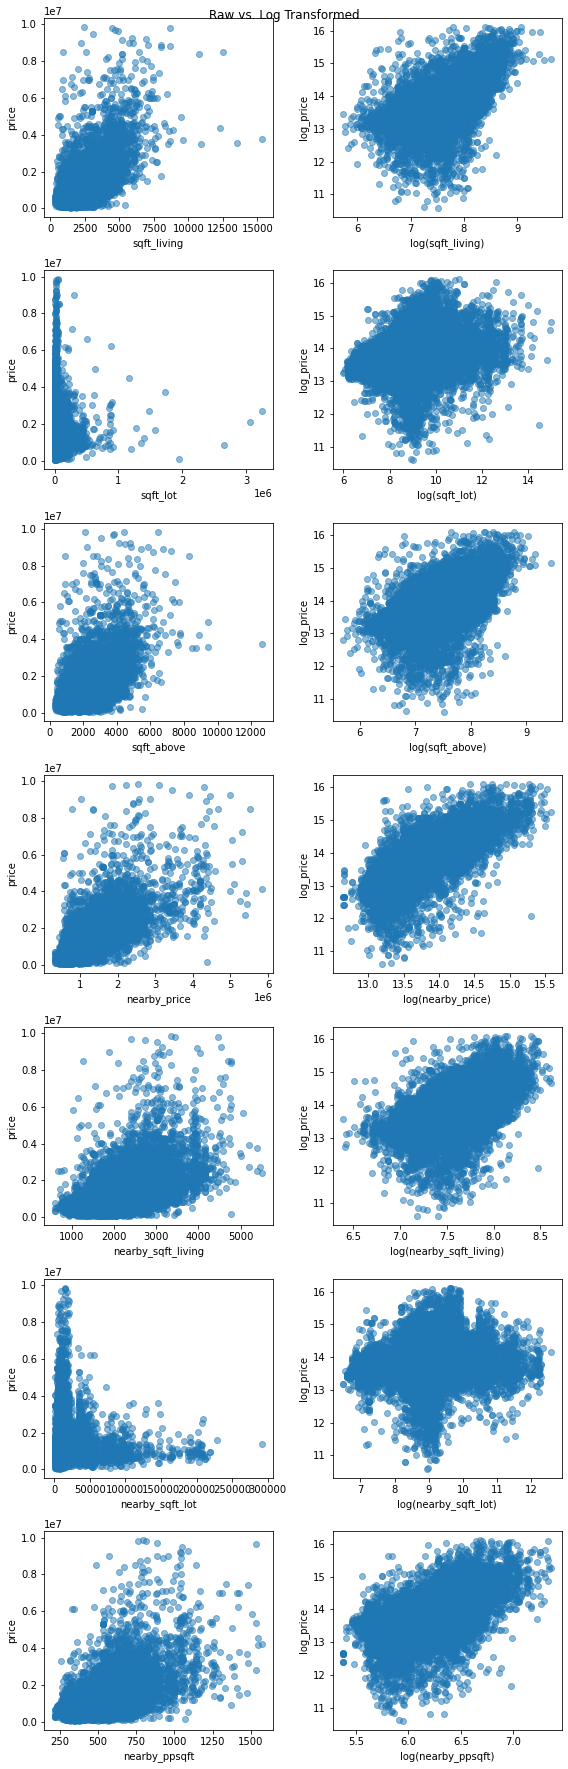

In [92]:
log_candidates = ['sqft_living', 'sqft_lot', 'sqft_above', 'nearby_price',
       'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft']

y = df['price']

fig, axes = plt.subplots(ncols=2, nrows=len(log_candidates), figsize=(8,25))

for i, column in enumerate(log_candidates):
    # Plot raw version
    left_ax = axes[i][0]
    left_ax.scatter(df[column], y, alpha=0.5)
    left_ax.set_xlabel(column)
    left_ax.set_ylabel('price')
    
    # Plot log transformed version
    right_ax = axes[i][1]
    right_ax.scatter(np.log(df[column]), np.log(y), alpha=0.5)
    right_ax.set_xlabel(f"log({column})")
    right_ax.set_ylabel("log_price")
    
fig.suptitle("Raw vs. Log Transformed")

fig.tight_layout();

It appears that *any*thing that's measured in square feet also looks better against the target variable when log-transformed. The clearest examples are:
- sqft_living
- nearby_price
- nearby_sqft_living
- nearby_ppsqft

We'll add log columns for those features.

In [93]:
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_nearby_price'] = np.log(df['nearby_price'])
df['log_nearby_sqft_living'] = np.log(df['nearby_sqft_living'])
df['log_nearby_ppsqft'] = np.log(df['nearby_ppsqft'])

In [94]:
corr_columns = ['price', 'log_price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
                'yr_built', 'yr_renovated', 'ppsqft', 'age', 'years_since_renovation',
                'nearby_price', 'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft',
                'nearby_age', 'log_sqft_living', 'log_nearby_price',
                'log_nearby_sqft_living', 'log_nearby_ppsqft']

In [95]:
df[corr_columns].corr()[['price', 'log_price']]

,price,log_price
price,1.000000,0.884868
log_price,0.884868,1.000000
bedrooms,0.322280,0.351355
bathrooms,0.512657,0.522076
sqft_living,0.648464,0.630066
sqft_lot,0.092789,0.086827
floors,0.220020,0.260002
sqft_above,0.573486,0.554836
sqft_basement,0.248384,0.247818
sqft_garage,0.284180,0.286659


## Column Maintenance
Before we explore interactions between variables, we want to create more features to potentially interact.

In [101]:
df['zip_tier_dupe'] = df['zip_tier']

In [102]:
df = pd.get_dummies(df, columns = [
    'waterfront', 'greenbelt', 'nuisance', 'city', 'zip', 'zip_tier'])
df.drop(columns = ['waterfront_NO', 'greenbelt_NO', 'nuisance_NO',
                               'zip_98422', 'city_White Center', 'zip_tier_0'], axis = 1, inplace = True)

In [103]:
df['heat_source'].value_counts()

Gas                  20118
Electricity           5931
Oil                   2892
Gas/Solar               92
Electricity/Solar       57
Other                   19
Oil/Solar                4
Name: heat_source, dtype: int64

The "sewer system" feature also has just 8 instances of "restricted" service, whatever that means.

In [104]:
df['sewer_system'].value_counts()

PUBLIC                24787
PRIVATE                4318
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         2
Name: sewer_system, dtype: int64

We'll fix these so that we have (slightly overlapping) categorical variables for each. That is, there will be a feature for "private" (1 if private, 0 if public) and another feature for "restricted" (1 if restricted, 0 if not).

In [105]:
df['gas'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Gas' else 0)
df['electricity'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Ele' else 0)
df['oil'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Oil' else 0)
df['solar'] = df['heat_source'].apply(lambda x: 1 if str(x)[-5:] == 'Solar' else 0)

df['sewer_system_private'] = df[
    'sewer_system'].apply(lambda x: 1 if str(x)[:7] == 'PRIVATE' else 0)
df['sewer_system_restricted'] = df[
    'sewer_system'].apply(lambda x: 1 if str(x)[-10:] == 'RESTRICTED' else 0)

Finally, we'll create some helpful groups for all of the columns we may wish to include in our model.

In [190]:
numeric_continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
                      'age', 'years_since_renovation']
nearby = ['nearby_price', 'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft', 'nearby_age']
logs = ['log_sqft_living', 'log_nearby_price', 'log_nearby_sqft_living', 'log_nearby_ppsqft']
numeric_discrete = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'zip_tier_dupe']
categorical = ['waterfront_YES', 'greenbelt_YES', 'nuisance_YES']
utilities = ['gas', 'electricity', 'oil', 'solar', 'sewer_system_private', 'sewer_system_restricted']
cities = ['city_Algona', 'city_Ames Lake', 'city_Auburn', 'city_Beaux Arts', 'city_Bellevue', 'city_Black Diamond',
          'city_Bothell', 'city_Burien', 'city_Carnation', 'city_Clyde Hill', 'city_Cottage Lake', 'city_Covington',
          'city_Dash Point', 'city_Des Moines', 'city_Dilworth', 'city_Duvall', 'city_Enumclaw', 'city_Fairwood',
          'city_Fall City', 'city_Federal Way', 'city_Hobart', 'city_Hunts Point', 'city_Issaquah', 'city_Kenmore',
          'city_Kent', 'city_Kirkland', 'city_Lake Forest Park', 'city_Lakeland North', 'city_Maple Valley',
          'city_Medina', 'city_Mercer Island', 'city_Milton', 'city_Newcastle', 'city_Normandy Park',
          'city_North Bend', 'city_Pacific', 'city_Preston', 'city_Ravensdale', 'city_Redmond', 'city_Renton',
          'city_Sammamish', 'city_SeaTac', 'city_Seattle', 'city_Shoreline', 'city_Snoqualmie', 'city_Tukwila',
          'city_Union Hill-Novelty Hill', 'city_Vashon', 'city_Woodinville', 'city_Yarrow Point']
zips = ['zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
        'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024', 'zip_98027',
        'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038',
        'zip_98039', 'zip_98040', 'zip_98042', 'zip_98045', 'zip_98047', 'zip_98050', 'zip_98051', 'zip_98052',
        'zip_98053', 'zip_98055', 'zip_98056', 'zip_98057', 'zip_98058', 'zip_98059', 'zip_98065', 'zip_98070',
        'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105',
        'zip_98106', 'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117',
        'zip_98118', 'zip_98119', 'zip_98122', 'zip_98125', 'zip_98126', 'zip_98133', 'zip_98136', 'zip_98144',
        'zip_98146', 'zip_98148', 'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178', 'zip_98188',
        'zip_98198', 'zip_98199', 'zip_98354']
tiers = ['zip_tier_1', 'zip_tier_2', 'zip_tier_3', 'zip_tier_4', 'zip_tier_5', 'zip_tier_6', 'zip_tier_7']

## Exploring Interactions Between Variables
We can isolate one of the lower zip code tiers with the highest and see that their scatterplots suggest different best-fit lines.

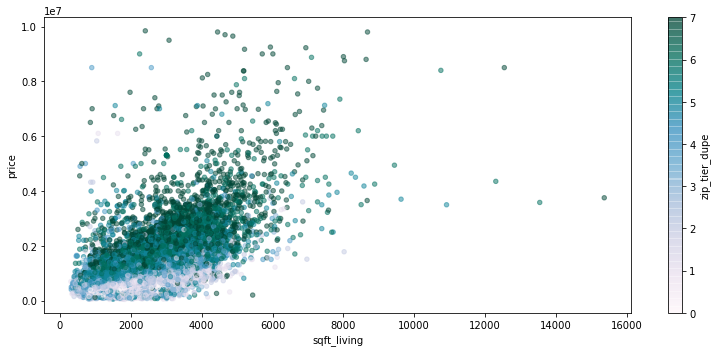

In [110]:
fig, ax = plt.subplots(figsize=(11,5))

df.plot.scatter(x='sqft_living', y='price', c='zip_tier_dupe', cmap='PuBuGn', alpha=0.5, ax=ax)
fig.tight_layout();

Let's plot fit lines for all the different zip code tiers against each other (and over a scatterplot of all the data).

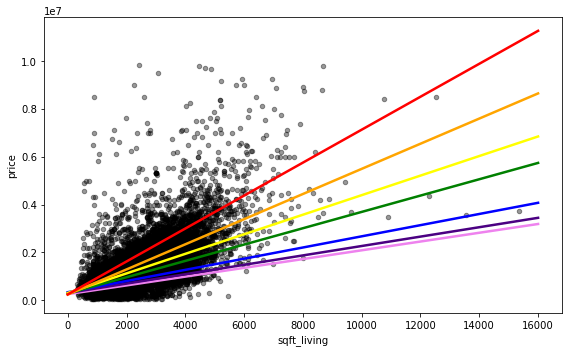

In [138]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot.scatter(x='sqft_living', y='price', alpha=0.4, ax=ax, color='black')

xseq = np.linspace(0, 16000, num=100)

dft1 = df[df['zip_tier_dupe'] == 1][['price', 'sqft_living']]
dft2 = df[df['zip_tier_dupe'] == 2][['price', 'sqft_living']]
dft3 = df[df['zip_tier_dupe'] == 3][['price', 'sqft_living']]
dft4 = df[df['zip_tier_dupe'] == 4][['price', 'sqft_living']]
dft5 = df[df['zip_tier_dupe'] == 5][['price', 'sqft_living']]
dft6 = df[df['zip_tier_dupe'] == 6][['price', 'sqft_living']]
dft7 = df[df['zip_tier_dupe'] == 7][['price', 'sqft_living']]

b1, a1 = np.polyfit(dft1['sqft_living'], dft1['price'], deg=1)
b2, a2 = np.polyfit(dft2['sqft_living'], dft2['price'], deg=1)
b3, a3 = np.polyfit(dft3['sqft_living'], dft3['price'], deg=1)
b4, a4 = np.polyfit(dft4['sqft_living'], dft4['price'], deg=1)
b5, a5 = np.polyfit(dft5['sqft_living'], dft5['price'], deg=1)
b6, a6 = np.polyfit(dft6['sqft_living'], dft6['price'], deg=1)
b7, a7 = np.polyfit(dft7['sqft_living'], dft7['price'], deg=1)

ax.plot(xseq, a1 + b1 * xseq, color='violet', lw=2.5)
ax.plot(xseq, a2 + b2 * xseq, color='indigo', lw=2.5)
ax.plot(xseq, a3 + b3 * xseq, color='blue', lw=2.5)
ax.plot(xseq, a4 + b4 * xseq, color='green', lw=2.5)
ax.plot(xseq, a5 + b5 * xseq, color='yellow', lw=2.5)
ax.plot(xseq, a6 + b6 * xseq, color='orange', lw=2.5)
ax.plot(xseq, a7 + b7 * xseq, color='red', lw=2.5)

fig.tight_layout();

This makes a strong case for interaction between sqft_living and the various zip code tiers.

Now we'll make a similar comparison for waterfront listings.

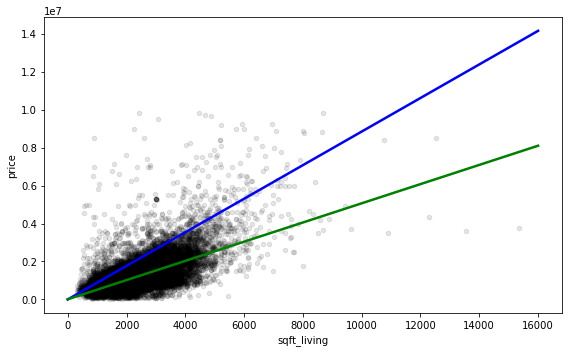

In [114]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot.scatter(x='sqft_living', y='price', alpha=0.1, ax=ax, color='black')

xseq = np.linspace(0, 16000, num=100)

df_water = df[df['waterfront_YES'] == 1][['price', 'sqft_living']]
df_land = df[df['waterfront_YES'] == 0][['price', 'sqft_living']]

b1, a1 = np.polyfit(df_water['sqft_living'], df_water['price'], deg=1)
b2, a2 = np.polyfit(df_land['sqft_living'], df_land['price'], deg=1)



ax.plot(xseq, a1 + b1 * xseq, color='blue', lw=2.5)
ax.plot(xseq, a2 + b2 * xseq, color='green', lw=2.5)

fig.tight_layout();

This seems like another clear interaction case. Let's look at the "view" feature.

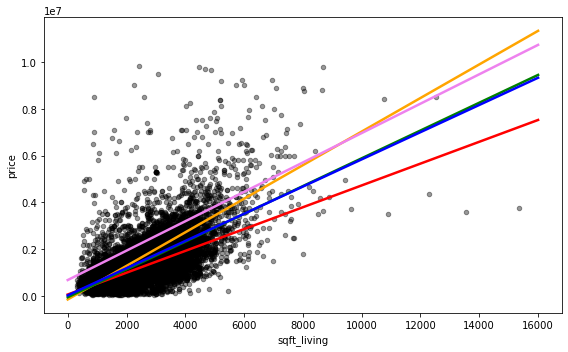

In [141]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot.scatter(x='sqft_living', y='price', alpha=0.4, ax=ax, color='black')

xseq = np.linspace(0, 16000, num=100)

dft1 = df[df['view'] == 0][['price', 'sqft_living']]
dft2 = df[df['view'] == 1][['price', 'sqft_living']]
dft3 = df[df['view'] == 2][['price', 'sqft_living']]
dft4 = df[df['view'] == 3][['price', 'sqft_living']]
dft5 = df[df['view'] == 4][['price', 'sqft_living']]

b1, a1 = np.polyfit(dft1['sqft_living'], dft1['price'], deg=1)
b2, a2 = np.polyfit(dft2['sqft_living'], dft2['price'], deg=1)
b3, a3 = np.polyfit(dft3['sqft_living'], dft3['price'], deg=1)
b4, a4 = np.polyfit(dft4['sqft_living'], dft4['price'], deg=1)
b5, a5 = np.polyfit(dft5['sqft_living'], dft5['price'], deg=1)

ax.plot(xseq, a1 + b1 * xseq, color='red', lw=2.5)
ax.plot(xseq, a2 + b2 * xseq, color='orange', lw=2.5)
ax.plot(xseq, a3 + b3 * xseq, color='green', lw=2.5)
ax.plot(xseq, a4 + b4 * xseq, color='blue', lw=2.5)
ax.plot(xseq, a5 + b5 * xseq, color='violet', lw=2.5)

fig.tight_layout();

This does *not* look like a good candidate for interaction.
## Adding Interaction Terms
We'll create the interaction terms and add them to their own column group

In [142]:
df['zip_interaction'] = df['sqft_living'] * df['zip_tier_dupe']
df['water_interaction'] = df['sqft_living'] * df['waterfront_YES']
interactions = ['zip_interaction', 'water_interaction']

# Modeling
## Baseline Model — Living Area Only

Let's review the strongest correlations and choose what feature(s) to include in a simple baseline.

In [115]:
df.corr()[['price']].sort_values('price')[-10:]

,price
nearby_ppsqft,0.561547
ppsqft,0.564604
log_sqft_living,0.567022
sqft_above,0.573486
grade,0.612528
sqft_living,0.648464
log_nearby_price,0.724652
nearby_price,0.760365
log_price,0.884868
price,1.000000


We obviously can't use log_price as a feature, as that would involve the target as a feature. But nearby_price should be fair game.

The strongest correlation among the original features is with sqft_living.

Let's make a simple baseline using sqft_living only.

In [126]:
y = df['price']
X_baseline = df[['sqft_living']]

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 2.112e+04
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:24:35   Log-Likelihood:            -4.2867e+05
No. Observations:               29113   AIC:                         8.573e+05
Df Residuals:                   29111   BIC:                         8.574e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.518e+04   8516.738     -2.956      

0.421 is not great, but it's good start to compare future models to.
## Nearby Features Model
Here we'll look at living area together with some of the "nearby" features we created.

We'll also standardize the values so that we can make apples-to-apples comparisons across coefficients.

In [191]:
y = df['price']
X_nearby = df[nearby].copy()

for col in X_nearby:
    X_nearby[col] = (X_nearby[col] - X_nearby[col].mean()) / X_nearby[col].std()


X_nearby_model = sm.OLS(y, sm.add_constant(X_nearby))
X_nearby_results = X_nearby_model.fit()

print(X_nearby_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     8021.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:14:47   Log-Likelihood:            -4.2400e+05
No. Observations:               29113   AIC:                         8.480e+05
Df Residuals:                   29107   BIC:                         8.481e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.102e+06   2997

This shows that nearby price is a strong predictor compared to all the others, especially nearby lot area, which was not significant.
## Kitchen Sink Model
Here we'll include everything that came with the original data set together with the adjusted features ("age", "years since renovation") and the created feature of "zip tiers".

We'll also standardize the values again.

In [127]:
y = df['price']
X_kitchen_sink = pd.concat([
    df[numeric_continuous], df[numeric_discrete], df[categorical], df[utilities]],
    axis=1)

for col in X_kitchen_sink:
    X_kitchen_sink[col] = (X_kitchen_sink[col] - X_kitchen_sink[col].mean()) / X_kitchen_sink[col].std()

kitchen_sink_model = sm.OLS(y, sm.add_constant(X_kitchen_sink))
kitchen_sink_results = kitchen_sink_model.fit()

print(kitchen_sink_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     2273.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:24:38   Log-Likelihood:            -4.2123e+05
No. Observations:               29113   AIC:                         8.425e+05
Df Residuals:                   29088   BIC:                         8.427e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

It's a much better R^2 at 0.652, but that's surely because we've piled so much into it. Let's focus on what we can learn from this model:

#### Bad p-values:
Most of the utilities information can be dropped on this basis.

#### Curiously Negative Coefficients:
Why would *more* garage area, bedrooms, or floors be a *bad* thing? Something odd or at least unhelpful is happening with those features. We'll drop them.

#### High and Low Coefficients:
Greenbelt, nuisance, and solar power have the lowest coefficients among the ones we're still considering. They can be dropped.

## Kitchen Sink "Lean" Model
We'll run a similarly large number of features, but stripping out the ones just discussed.

We should also drop the features that we discovered to be multicollinear with living area: sqft_above, bathrooms, and grade.

In [128]:
y = df['price']
X_kitchen_sink_lean = X_kitchen_sink.copy().drop([
    'gas', 'electricity', 'oil', 'solar', 'sewer_system_restricted',
    'sqft_garage', 'bedrooms', 'floors', 'greenbelt_YES', 'nuisance_YES', 'sqft_above', 'bathrooms', 'grade'],
    axis=1)

kitchen_sink_lean_model = sm.OLS(y, sm.add_constant(X_kitchen_sink_lean))
kitchen_sink_lean_results = kitchen_sink_lean_model.fit()

print(kitchen_sink_lean_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4476.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:25:22   Log-Likelihood:            -4.2219e+05
No. Observations:               29113   AIC:                         8.444e+05
Df Residuals:                   29101   BIC:                         8.445e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.10

Once again, there's a curiously negative coefficient (basement area), and some coefficients lower than the others (condition, patio area, lot area, and years since renovation). Those could be dropped in future models.

## Geography-Interactions Model
First we'll look at a model that uses *only* living area, label-encoded zip code tiers, and the waterfront feature.

Then we'll compare this to a model that adds interactions for those features.

In [151]:
y = df['price']
X_geography = pd.concat([df[['sqft_living', 'zip_tier_dupe', 'waterfront_YES']]], axis=1)

X_geography_model = sm.OLS(y, sm.add_constant(X_geography))
X_geography_results = X_geography_model.fit()

print(X_geography_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 1.499e+04
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:50:26   Log-Likelihood:            -4.2301e+05
No. Observations:               29113   AIC:                         8.460e+05
Df Residuals:                   29109   BIC:                         8.461e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.948e+05   8242.628    -60.

In [192]:
y = df['price']
X_geography_interactions = pd.concat([df[['sqft_living', 'zip_tier_dupe', 'waterfront_YES']],
                                      df[interactions]], axis=1)

X_geography_interactions_model = sm.OLS(y, sm.add_constant(X_geography_interactions))
X_geography_interactions_results = X_geography_interactions_model.fit()

print(X_geography_interactions_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                 1.175e+04
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:19:45   Log-Likelihood:            -4.2053e+05
No. Observations:               29113   AIC:                         8.411e+05
Df Residuals:                   29107   BIC:                         8.411e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.597e+05   1.56e+0

The interactions have a significant effect on the R^2 value. Interestingly, the actual waterfront_YES variable by itself doesn't seem to be significant.
## Final Model
This model takes what we've learned from the other models and uses only the strongest features.

In playing around with the features for this model, we found that we could strip away the bare "sqft_living" term without any loss — its effect is still seen in both of the interaction terms.

In [203]:
y = df['price']
X_final = df[['view', 'sewer_system_private', 'zip_tier_dupe',
             'zip_interaction', 'water_interaction', 'nearby_price']].copy()

X_final_model = sm.OLS(y, sm.add_constant(X_final))
X_final_results = X_final_model.fit()

print(X_final_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 1.343e+04
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:26:38   Log-Likelihood:            -4.1730e+05
No. Observations:               29113   AIC:                         8.346e+05
Df Residuals:                   29106   BIC:                         8.347e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.743e+05 